# Carbide detection algorithm explanation

In order to detect carbides in SEM images, we use the following workflow:

## Workflow

In [1]:
import carde
import stackview
from sklearn.metrics import f1_score, jaccard_score
import numpy as np
import pandas as pd
from skimage.io import imsave
import SimpleITK as sitk

### Loading Image set

In [3]:
image_set = carde.io.read_matching_images(47)

[[138 140 140 ... 143 151 153]
 [137 145 137 ... 147 143 137]
 [137 142 139 ... 142 142 139]
 ...
 [112 108 112 ... 119 115 113]
 [122 122 113 ... 112 115 112]
 [  0   0   0 ...   0 115 116]]
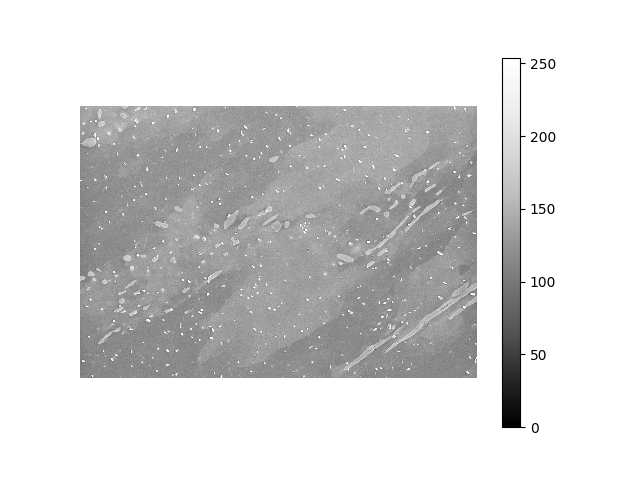
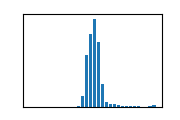

In [4]:
stackview.insight(image_set["Image1"])

[[122 128 131 ... 124 126 134]
 [122 123 124 ... 129 132 134]
 [125 120 119 ... 130 130 136]
 ...
 [114 118 123 ... 120 120 128]
 [131 124 126 ... 126 125 127]
 [  0   0   0 ...   0 133 121]]
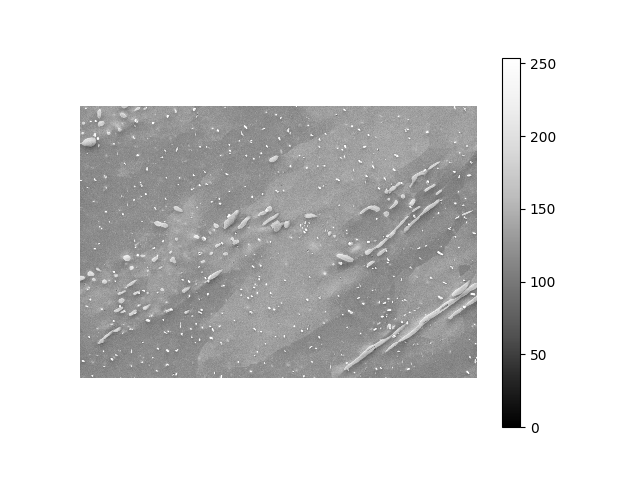
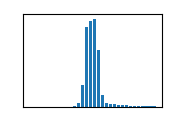

In [5]:
stackview.insight(image_set["Image2"])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
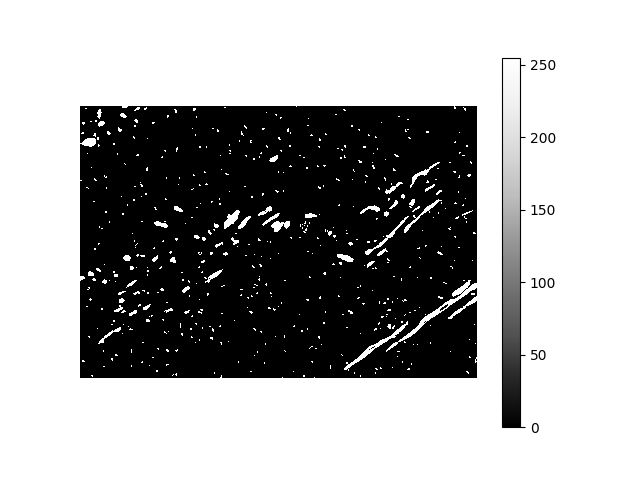
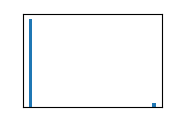

In [6]:
stackview.insight(image_set["label"])

### Combine SE2 and InLens images

[[130 134 135 ... 133 138 143]
 [129 133 130 ... 137 137 135]
 [130 131 128 ... 136 136 137]
 ...
 [113 113 117 ... 119 117 120]
 [126 123 119 ... 119 119 119]
 [  0   0   0 ...   0 123 118]]
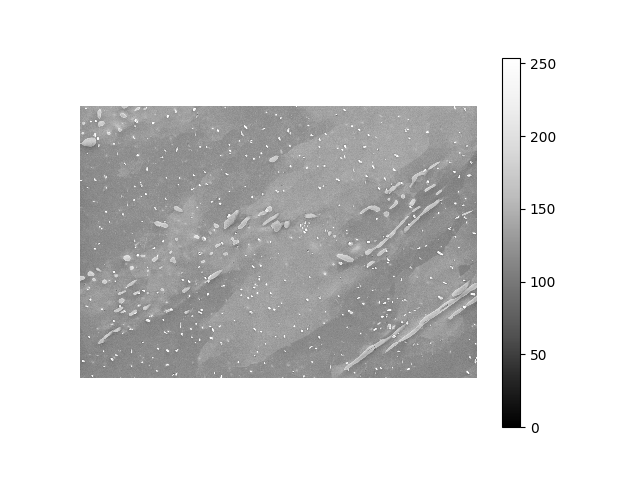
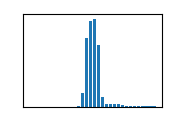

In [7]:
combined = image_set["Image2"] // 2 + image_set["Image1"] // 2
stackview.insight(combined)

### Denoise using a Gaussian blur filter

[[130 131 132 ... 134 136 138]
 [129 130 130 ... 136 136 136]
 [129 129 129 ... 135 135 135]
 ...
 [106 106 105 ... 111 115 118]
 [ 87  86  85 ...  93 110 117]
 [ 31  31  30 ...  54  96 113]]
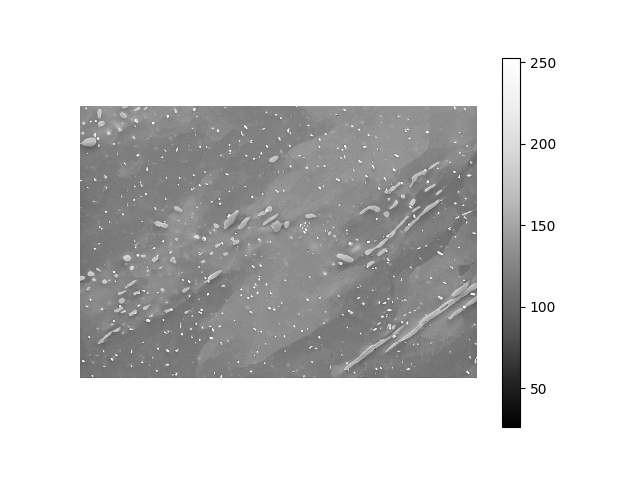
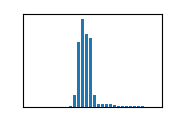

In [8]:
image1_gb = sitk.DiscreteGaussian(sitk.GetImageFromArray(combined), variance=[1, 1])
stackview.insight(sitk.GetArrayViewFromImage(image1_gb))

### Remove background using a top hat filter

[[0 0 1 ... 0 0 0]
 [0 1 1 ... 2 1 0]
 [0 0 0 ... 1 1 0]
 ...
 [1 3 2 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
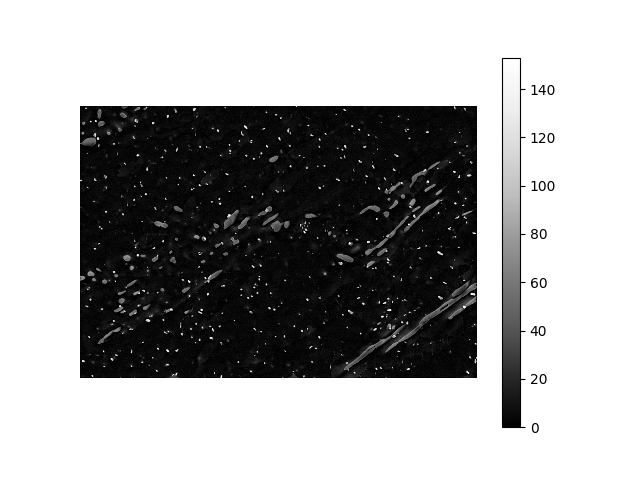
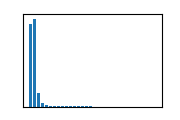

In [9]:
image2_thb = sitk.WhiteTopHat(image1_gb, kernelRadius=[30, 30])
stackview.insight(sitk.GetArrayViewFromImage(image2_thb))

### Segment the image using Otsu's threshold method

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
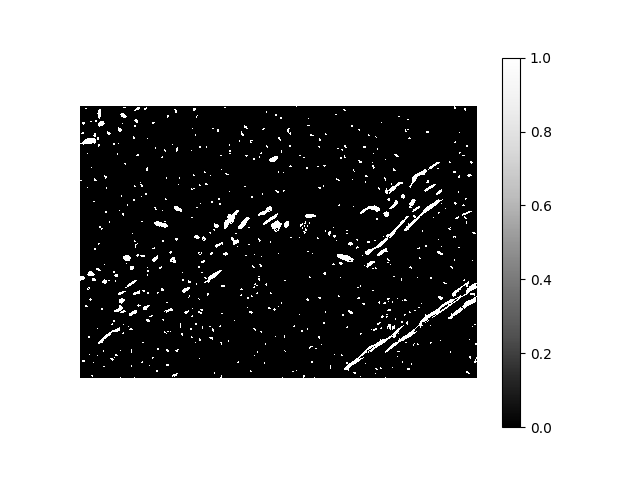
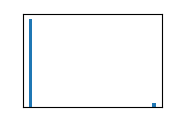

In [10]:
image3_T = sitk.OtsuThreshold(image2_thb, 0, 1)
stackview.insight(sitk.GetArrayViewFromImage(image3_T))

### Binary fill holes

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
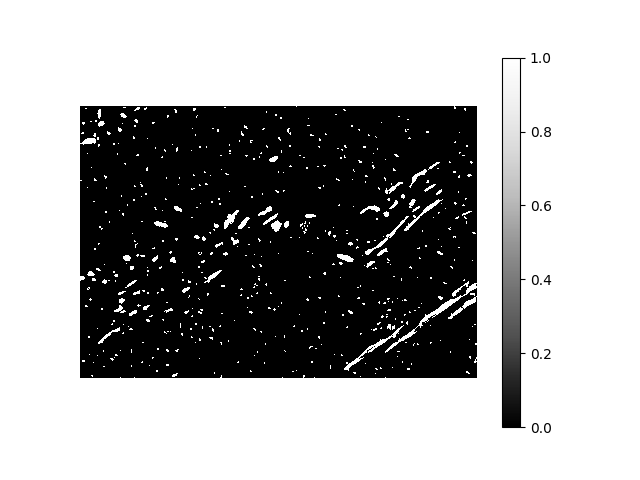
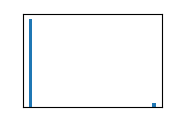

In [11]:
image4_B = sitk.BinaryFillhole(image3_T)
stackview.insight(sitk.GetArrayViewFromImage(image4_B))

### Connected components labeling

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
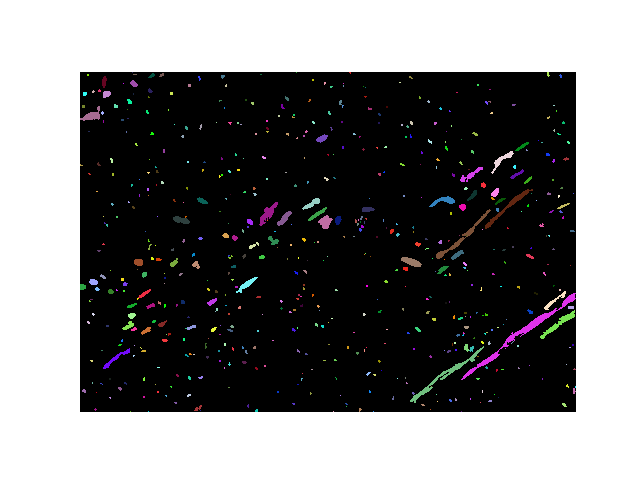

In [12]:
image5_C = sitk.ConnectedComponent(image4_B)
stackview.insight(sitk.GetArrayViewFromImage(image5_C))

### Exclude small objects

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
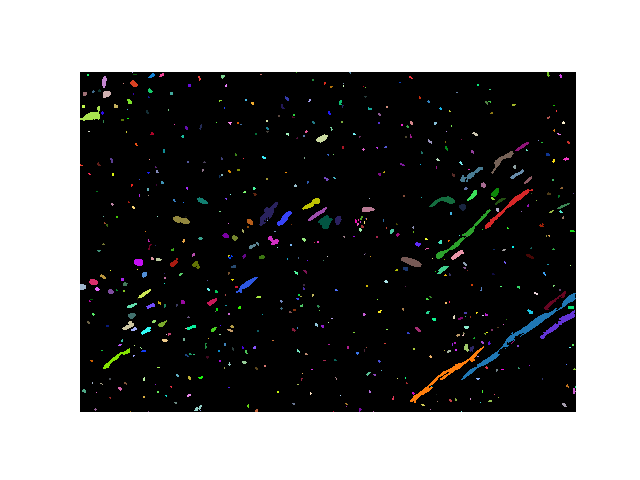

In [13]:
image6_R = sitk.RelabelComponent(image5_C)
stackview.insight(sitk.GetArrayViewFromImage(image6_R))

### Shortcut

This shortcut function performs all steps described above in one go

In [14]:
segmented_image1 = carde.segment_otsu(image_set["Image1"])
segmented_image2 = carde.segment_otsu(image_set["Image2"])

### Combine SE2 and InLens images

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
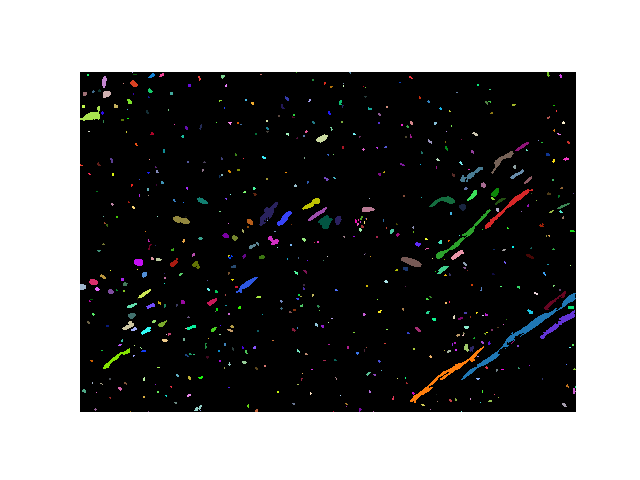

In [15]:
combined_segmentation = carde.segment_combined(image_set["Image1"], image_set["Image2"])
stackview.insight(combined_segmentation)

## Evaluate segmentation quality

In [16]:
f1_image1 = f1_score(image_set["label"], np.asarray(segmented_image1 > 0), average="micro")
f1_image1

0.8920817100539458

In [17]:
jaccard_image1 = jaccard_score(image_set["label"], np.asarray(segmented_image1 > 0), average="micro")
jaccard_image1

0.8051872761279013

In [18]:
f1_image2 = f1_score(image_set["label"], np.asarray(segmented_image2 > 0), average="micro")
f1_image2

0.8686982428976939

In [19]:
jaccard_image2 = jaccard_score(image_set["label"], np.asarray(segmented_image2 > 0), average="micro")
jaccard_image2

0.7678749170537492

In [19]:
f1_combined = f1_score(image_set["label"], np.asarray(combined_segmentation > 0), average="micro")
f1_combined

0.9069256659294163

In [20]:
jaccard_combined = jaccard_score(image_set["label"], np.asarray(combined_segmentation > 0), average="micro")
jaccard_combined

np.float64(0.8297017299382065)

### Create a table with the results


In [21]:
data = {
    "Source": ["Image1", "Image2", "Combined", "Image1", "Image2", "Combined"],
    "Test": ["F1", "F1", "F1", "Jaccard", "Jaccard", "Jaccard"],
    "Score": [f1_image1, f1_image2, f1_combined, jaccard_image1, jaccard_image2, jaccard_combined],
}
df = pd.DataFrame(data)
df

,Source,Test,Score
0,Image1,F1,0.892082
1,Image2,F1,0.868698
2,Combined,F1,0.906926
3,Image1,Jaccard,0.805187
4,Image2,Jaccard,0.767875
5,Combined,Jaccard,0.829702


### Plot the results as a horizontal bar plot


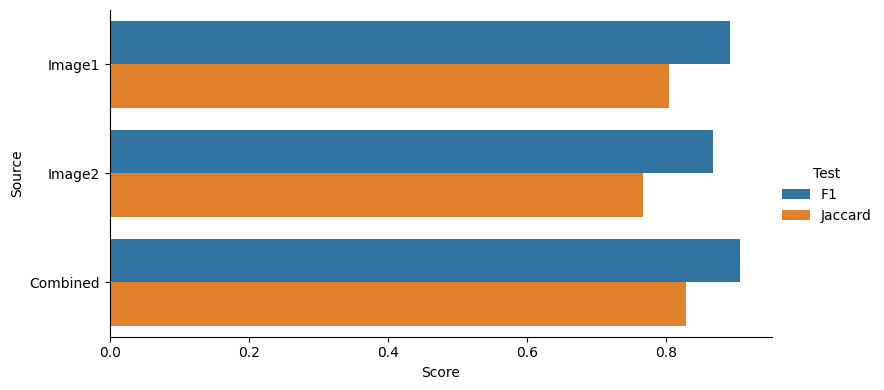

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

_ = sns.catplot(data=df, x="Score", y="Source", hue="Test", kind="bar", height=4, aspect=2)

## Evaluate and save best results

Combined image gives best results

In [23]:
results = carde.image_processing.evaluate_segmentation(np.asarray(combined_segmentation))
results

,label,area,axis_major_length,axis_minor_length,centroid-0,centroid-1,orientation
0,1,0.332315,3.529616,0.188669,1079.557816,1825.469769,-0.935721
1,2,0.186574,2.303241,0.158857,1253.806286,1507.292804,-0.950245
2,3,0.132747,1.883236,0.157438,683.892583,1578.185771,-0.841923
3,4,0.120802,1.605410,0.125030,559.736331,1767.569750,-0.855160
4,5,0.104846,1.118957,0.139903,1040.964969,1976.962025,-0.931940
...,...,...,...,...,...,...,...
647,648,0.000093,0.012830,0.007407,230.666667,565.666667,-0.785398
648,649,0.000093,0.012830,0.007407,521.333333,447.333333,-0.785398
649,650,0.000093,0.012830,0.007407,1105.333333,1799.666667,0.785398
650,651,0.000093,0.012830,0.007407,1282.666667,1311.333333,0.785398


In [24]:
imsave("combined_segmentation.tif", np.asarray(combined_segmentation))
results.to_csv("results.csv")

/opt/homebrew/Caskroom/mambaforge/base/envs/carde-env/lib/python3.11/site-packages/skimage/_shared/utils.py:328: UserWarning: combined_segmentation.tif is a low contrast image
  return func(*args, **kwargs)


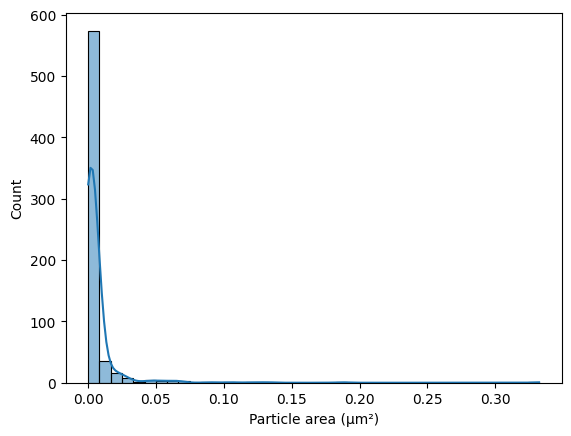

In [25]:
# Plot a histogram of the particle area with seaborn

ax = sns.histplot(data=results, x="area", bins=40, kde=True)
_ = ax.set_xlabel("Particle area (µm²)")

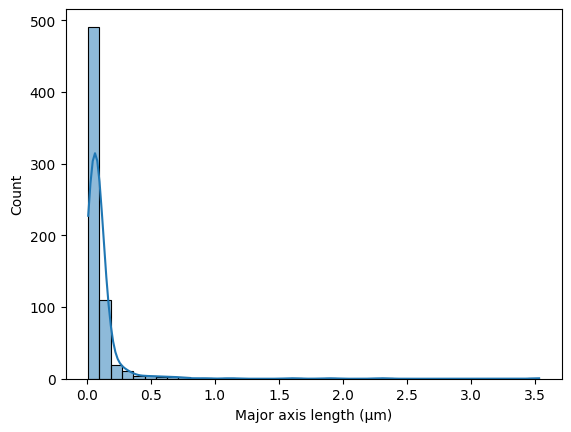

In [26]:
ax = sns.histplot(data=results, x="axis_major_length", bins=40, kde=True)
_ = ax.set_xlabel("Major axis length (µm)")